In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

from sdebridge.setup import *
from sdebridge.sde import SDE
from sdebridge.diffusion_bridge import DiffusionBridge

from matplotlib import colormaps

2024-01-25 20:55:48.854824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 20:55:48.854856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 20:55:48.855900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 20:55:50.205961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

In [3]:
def batch_matmul(A: jnp.ndarray, B: jnp.ndarray) -> jnp.ndarray:
    """Batch matrix multiplication"""
    return vmap(jnp.matmul)(A, B)

@partial(jax.jit, static_argnums=(0, ), backend='cpu')
def euler_maruyama(
    sde: SDE,
    initial_vals: jnp.ndarray,
    terminal_vals: jnp.ndarray,
    rng_key: jax.Array = GDRK,
) -> dict:
    """Euler-Maruyama solver for SDEs

    initial_vals: (B, N, 2), complex64
    terminal_vals: (B, N, 2), complex64
    """
    enforce_terminal_constraint = terminal_vals is not None

    SolverState = namedtuple("SolverState", ["vals", "grads", "step_key"])
    init_state = SolverState(
        vals=initial_vals,
        grads=jnp.empty_like(initial_vals),
        step_key=rng_key,
    )

    def euler_maruyama_step(state: SolverState, time: ArrayLike) -> tuple:
        """Euler-Maruyama step, NOTE: all the calculations are over batches"""
        step_key, _ = random.split(state.step_key)
        _drift = vmap(sde.drift, in_axes=(0, None))(state.vals, time)  # (B, N, 2)
        drift_step = _drift * sde.dt
        
        n_batches, n_bases, dim = state.vals.shape
        _brownian = random.normal(step_key, shape=(n_batches, n_bases**2, dim))  # (B, N^2, 2)
        brownian_step = _brownian * jnp.sqrt(sde.dt)

        _diffusion = vmap(sde.diffusion, in_axes=(0, None))(
            state.vals, time
        )  # (B, N, N^2)
        diffusion_step = batch_matmul(_diffusion, brownian_step)  # (B, N, 2)

        _inv_covariance = vmap(sde.inv_covariance, in_axes=(0, None))(
            state.vals, time
        )  # (B, N, N)

        grads = -batch_matmul(_inv_covariance, diffusion_step) / sde.dt  # (B, N, 2)

        new_vals = state.vals + drift_step + diffusion_step  # (B, N, 2)
        new_state = SolverState(
            vals=new_vals,
            grads=grads,
            step_key=step_key,
        )
        return new_state, (
            state.vals,
            state.grads,
            state.step_key,
        )

    _, (trajectories, gradients, step_keys) = jax.lax.scan(
        euler_maruyama_step,
        init=init_state,
        xs=(sde.ts[:-1]),
        length=sde.N,
    )

    if enforce_terminal_constraint:
        trajectories = trajectories.at[-1].set(terminal_vals)
    return {
        "trajectories": jnp.swapaxes(trajectories, 0, 1),
        "gradients": jnp.swapaxes(gradients, 0, 1),
        "last_key": step_keys[-1],
    }

In [394]:
# n_bases = 16
# n_samples = 64
# # xi_s = 2.0 * jnp.pi * jnp.arange(n_bases) / n_bases
# xi_s = 2.0 * jnp.pi * jnp.arange(0, n_bases) / n_bases
# eta1_s, eta2_s = jnp.meshgrid(xi_s, xi_s, indexing='ij')
# eta_s = jnp.stack([eta1_s, eta2_s], axis=-1)
# print(eta_s.shape)

# fourier_base_func_1d = lambda idx, xi: jnp.exp(1j * idx * xi)

# def evalute_initial_shape(S0: jnp.ndarray) -> jnp.ndarray:
#     n_samples = S0.shape[0]
#     S0_fft = vmap(partial(jnp.fft.fft, norm="ortho"), in_axes=1, out_axes=1)(S0) # (n_samples, 2)
#     base = lambda xi: jnp.exp(1j * jnp.arange(n_samples) * xi) # (n_samples, )
#     bases = vmap(base)(xi_s) # (n_bases, n_samples)
#     S0_xi = jnp.matmul(bases, S0_fft) / jnp.sqrt(n_samples) # (n_bases, 2)
#     return S0_xi

# def evaluate_current_pos(coeffs: jnp.ndarray, S0_xi: jnp.ndarray) -> jnp.ndarray:
#     # evaluate for all xi, i.e. all bases
#     coeffs_normalized = coeffs / jnp.sqrt(n_bases)
#     X_xi = vmap(jnp.fft.ifft, in_axes=1, out_axes=1)(coeffs_normalized)     # (n_bases, 2)
#     return X_xi + S0_xi

# def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
#     return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

# def evaluate_kernel(coeffs: jnp.ndarray, S0_xi: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
#     kernel_func = partial(gaussian_kernel_2d, sigma=sigma, alpha=alpha)
#     curr_pos = evaluate_current_pos(coeffs, S0_xi)    # (n_bases, 2)
#     kernel = vmap(
#         vmap(
#             vmap(kernel_func, 
#                  (None, 0), 
#                  0), 
#             (None, 1), 
#             1), 
#         (0, None), 
#         0)(curr_pos, eta_s)
#     return kernel

# def evaluate_Q(coeffs: jnp.ndarray, S0_xi: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
#     kernel = evaluate_kernel(coeffs, S0_xi, sigma, alpha) # (n_bases, n_bases, n_bases)
#     kernel_fft = vmap(partial(jnp.fft.fft2, norm="forward"))(kernel)    # (n_bases, n_bases, n_bases)
#     kernel_fft = kernel_fft.reshape(n_bases, -1)    # (n_bases, n_bases ** 2)
#     return kernel_fft

# def evaluate_diffusion(coeffs: jnp.ndarray, S0_xi: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
#     Q = evaluate_Q(coeffs, S0_xi, sigma, alpha) # (n_bases, n_bases ** 2)
#     fs = vmap(fourier_base_func_1d, (0, None))(jnp.arange(n_bases), xi_s)
#     return jnp.matmul(fs, Q)    # (n_bases, n_bases**2)

(16, 16, 2)


### Truncate and leave the first part of low-frequency bases

In [134]:
n_bases = 64
n_samples = 64
ks = jnp.fft.fftshift(jnp.fft.fftfreq(n_samples, d=1.0/(2.0*np.pi)))    # (n_samples, )
ks_truncated = ks[(n_samples-n_bases)//2:(n_samples+n_bases)//2]  # (n_bases, )
kks = jnp.stack(jnp.meshgrid(ks, ks, indexing='ij'), axis=-1)
kks_truncated = jnp.stack(jnp.meshgrid(ks_truncated, ks_truncated, indexing='ij'), axis=-1)
kks_truncated = jnp.fft.fftshift(kks_truncated, axes=(0, 1))
print(kks.shape)

(64, 64, 2)


In [135]:
fourier_base_func_1d = lambda m, k: jnp.exp(1j * m * k)

def evalute_S_on_bases(S: jnp.ndarray, ks: jnp.ndarray) -> jnp.ndarray:
    n_samples = S.shape[0]
    S_fft = vmap(partial(jnp.fft.fft, norm="ortho"), in_axes=1, out_axes=1)(S) # (n_samples, 2)
    S_fft_shifted = jnp.fft.fftshift(S_fft, axes=0) # (n_samples, 2)
    base = lambda k: jnp.exp(1j * jnp.arange(-n_samples//2, n_samples//2) * k) # (n_samples, )
    bases = vmap(base)(ks) # (n_bases, n_samples)
    S_eval = jnp.matmul(bases, S_fft_shifted) / jnp.sqrt(n_samples) # (n_bases, 2)
    return S_eval

def evaluate_X_on_bases(X_coeffs: jnp.ndarray, ks: jnp.ndarray) -> jnp.ndarray:
    assert X_coeffs.shape[0] == len(ks)
    X_eval = vmap(partial(jnp.fft.irfft, norm="forward", n=n_bases), in_axes=1, out_axes=1)(X_coeffs / jnp.sqrt(n_samples))     # (n_bases, 2)
    return X_eval

def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

def evaluate_Q_on_bases(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, ks: jnp.ndarray, kks: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    kernel_func = partial(gaussian_kernel_2d, sigma=sigma, alpha=alpha)
    St_eval = evaluate_X_on_bases(X_coeffs, ks) + S0_eval   # (n_bases, 2)
    Q_eval = vmap(
        vmap(
            vmap(kernel_func, 
                 (None, 0), 
                 0), 
            (None, 1), 
            1), 
        (0, None), 
        0)(St_eval, kks)
    return Q_eval

def evaluate_Q_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, ks: jnp.ndarray, kks: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_eval = evaluate_Q_on_bases(X_coeffs, S0_eval, ks, kks, sigma, alpha) # (n_bases, n_bases, n_bases)
    Q_coeffs = vmap(partial(jnp.fft.fft2, norm="forward"))(Q_eval)    # (n_bases, n_bases, n_bases)
    Q_coeffs_shifted = jnp.fft.fftshift(Q_coeffs, axes=(-2, -1))
    Q_coeffs_shifted = Q_coeffs_shifted.reshape(n_bases, -1)    # (n_bases, n_bases ** 2)
    return Q_coeffs_shifted

def evaluate_diffusion_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, ks: jnp.ndarray, kks: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_coeffs_shifted = evaluate_Q_coeffs(X_coeffs, S0_eval, ks, kks, sigma, alpha) # (n_bases, n_bases ** 2)
    fs = vmap(fourier_base_func_1d, (0, None))(jnp.arange(-n_bases//2, n_bases//2), ks)
    return jnp.matmul(fs, Q_coeffs_shifted)    # (n_bases, n_bases**2)


def sample_ellipse(
    n_samples: int,
    scale: float = 1.0,
    shifts: np.ndarray = np.array([0.0, 0.0]),
    a: float = 1.0,
    b: float = 1.0,
) -> np.ndarray:
    theta = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    return scale * np.stack([x, y], axis=1) + shifts[None, :]

S0 shape:  (64, 2)
ST shape:  (64, 2)


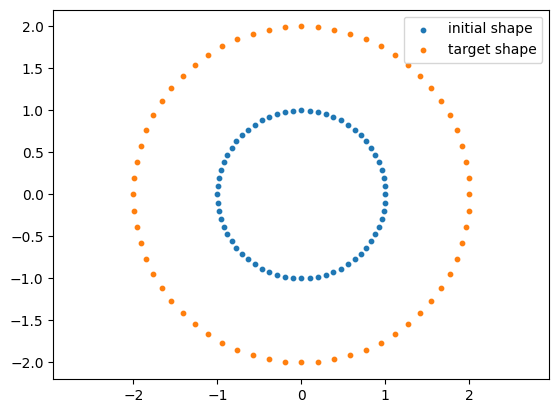

In [136]:
S0 = sample_ellipse(n_samples, scale=1.0)
ST = sample_ellipse(n_samples, scale=2.0)
print("S0 shape: ", S0.shape)
print("ST shape: ", S0.shape)
plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
plt.legend()
plt.axis('equal')
plt.show()

diffusion shape:  (64, 4096)


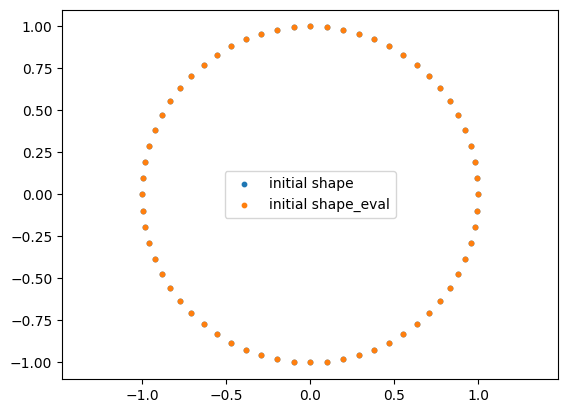

In [137]:
S0_eval = evalute_S_on_bases(S0, ks_truncated)
X_coeffs = jax.random.normal(GDRK, shape=(n_bases, 2), dtype=jnp.complex64)
_diffusion = evaluate_diffusion_coeffs(X_coeffs, S0_eval, ks_truncated, kks_truncated, sigma=0.5, alpha=1.0)
print("diffusion shape: ", _diffusion.shape)

plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(S0_eval[:, 0], S0_eval[:, 1], s=10, label='initial shape_eval')
plt.axis('equal')
plt.legend()

In [138]:
from sdebridge.sde import SDE

class GaussianKernelFuncBasisSDE(SDE):
    def __init__(self, config: ConfigDict):
        self.config = config

    def drift(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return jnp.zeros_like(val)
    
    def diffusion(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return evaluate_diffusion_coeffs(val, self.config.S0_eval, self.config.ks, self.config.kks, self.config.sigma, self.config.alpha)

In [139]:
sde_config = ConfigDict(
    {
        'S0_eval': S0_eval,
        'T': 1.0,
        'N': 100,
        'dim': 2*n_bases,
        'ks': ks_truncated,
        'kks': kks_truncated,
        'sigma': 1.0,
        'alpha': 1.0,
    }
)
sde = GaussianKernelFuncBasisSDE(sde_config)
bridge = DiffusionBridge(sde)

XT shape: 
 (64, 2)
XT coefficients (complex) shape: 
 (64, 2)
XT (reconstructed) shape: 



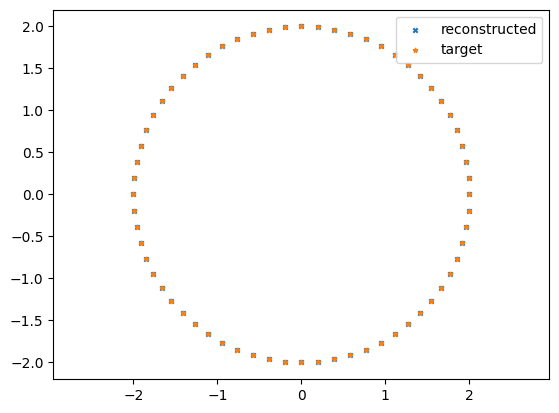

In [140]:
X0 = jnp.zeros((n_bases, 2), dtype=jnp.complex64)

XT = ST - S0
print("XT shape: \n", XT.shape)
XT_coeffs= vmap(partial(jnp.fft.fft, norm="backward", n=n_samples), in_axes=1, out_axes=1)(XT)
XT_coeffs_shifted = jnp.fft.fftshift(XT_coeffs, axes=0)
XT_coeffs_shifted_truncated = XT_coeffs[(n_samples-n_bases)//2:(n_samples+n_bases)//2+1, :]
XT_coeffs_truncated = jnp.fft.ifftshift(XT_coeffs_shifted_truncated, axes=0)
print("XT coefficients (complex) shape: \n", XT_coeffs_truncated.shape)
XT_recon = vmap(partial(jnp.fft.ifft, norm="backward", n=n_samples), in_axes=1, out_axes=1)(XT_coeffs)
print("XT (reconstructed) shape: \n")

ST_recon = S0 + XT_recon.real
plt.scatter(ST_recon[:, 0], ST_recon[:, 1], s=10, marker='x', label='reconstructed')
plt.scatter(ST[:, 0], ST[:, 1], s=10, marker='*', label='target')
plt.axis('equal')
plt.legend()

In [141]:
forward_uncond = euler_maruyama(sde, initial_vals=jnp.expand_dims(X0, axis=0), terminal_vals=None)

Xs_coeffs shape:  (1, 100, 64, 2)
Xs_recon shape:  (1, 100, 64, 2)
Ss shape:  (1, 100, 64, 2)


(-1.3503567337989808,
 1.4349416851997376,
 -1.6535740554332734,
 1.539873069524765)

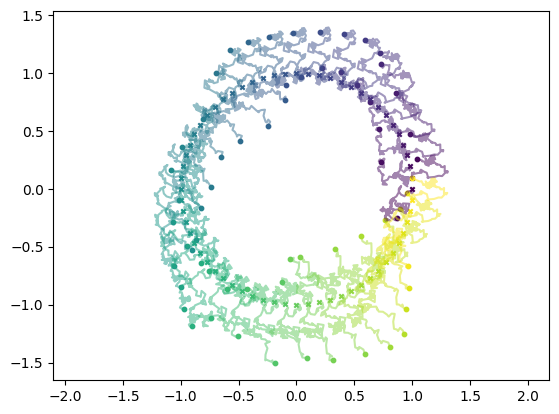

In [142]:
Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: ", Xs_coeffs.shape)
Xs_recon = vmap(vmap(vmap(partial(jnp.fft.ifft, norm="backward", n=n_samples), in_axes=1, out_axes=1)))(Xs_coeffs)
print("Xs_recon shape: ", Xs_recon.shape)

Ss = S0[None, None, :, :] + Xs_recon.real
print("Ss shape: ", Ss.shape)

# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_samples))
for i in range(n_samples):
    plt.scatter(Ss[0, 0, i, 0], Ss[0, 0, i, 1], s=10, marker='x', color=colors[i])
    plt.scatter(Ss[0, -1, i, 0], Ss[0, -1, i, 1], s=10, marker='o', color=colors[i])
    plt.plot(Ss[0, :, i, 0], Ss[0, :, i, 1], color=colors[i], alpha=0.5)
plt.axis('equal')

### Don't do truncation instead of using a more sparse grid (evenly sampled frequency bases)

In [221]:
n_bases = 16
n_samples = 64

ks_truncated = jnp.fft.fftfreq(n_bases, d=1.0/(2.0*np.pi))  # (n_bases, )
kks_truncated = jnp.stack(jnp.meshgrid(ks_truncated, ks_truncated, indexing='ij'), axis=-1)

In [222]:
def evaluate_S_on_bases(S: jnp.ndarray) -> jnp.ndarray:
    S_coeffs = vmap(partial(jnp.fft.fft, norm="ortho", n=n_samples), in_axes=1, out_axes=1)(S)
    S_eval = vmap(partial(jnp.fft.irfft, norm="forward", n=n_bases), in_axes=1, out_axes=1)(S_coeffs / np.sqrt(n_samples))
    return S_eval

def evaluate_X_on_bases(X_coeffs: jnp.ndarray, n: int) -> jnp.ndarray:
    X_eval = vmap(partial(jnp.fft.irfft, norm="forward", n=n), in_axes=1, out_axes=1)(X_coeffs / jnp.sqrt(n_samples))
    return X_eval

def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

def evaluate_Q_on_bases(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    kernel_func = partial(gaussian_kernel_2d, sigma=sigma, alpha=alpha)
    St_eval = evaluate_X_on_bases(X_coeffs) + S0_eval   # (n_bases, 2)
    Q_eval = vmap(
        vmap(
            vmap(kernel_func, 
                 (None, 0), 
                 0), 
            (None, 1), 
            1), 
        (0, None), 
        0)(St_eval, kks_truncated)
    return Q_eval

def evaluate_Q_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_eval = evaluate_Q_on_bases(X_coeffs, S0_eval, sigma, alpha) # (n_bases, n_bases, n_bases)
    Q_coeffs = vmap(partial(jnp.fft.fft2, norm="forward"))(Q_eval)    # (n_bases, n_bases, n_bases)
    Q_coeffs_shifted = jnp.fft.fftshift(Q_coeffs, axes=(-2, -1))
    Q_coeffs_shifted = Q_coeffs_shifted.reshape(n_bases, -1)    # (n_bases, n_bases ** 2)
    return Q_coeffs_shifted

def evaluate_diffusion_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_coeffs_shifted = evaluate_Q_coeffs(X_coeffs, S0_eval, sigma, alpha) # (n_bases, n_bases ** 2)
    fs = vmap(fourier_base_func_1d, (0, None))(jnp.arange(n_bases), ks_truncated)
    return jnp.matmul(fs, Q_coeffs_shifted)    # (n_bases, n_bases**2)

#### Circles

S0 shape:  (64, 2)
ST shape:  (64, 2)


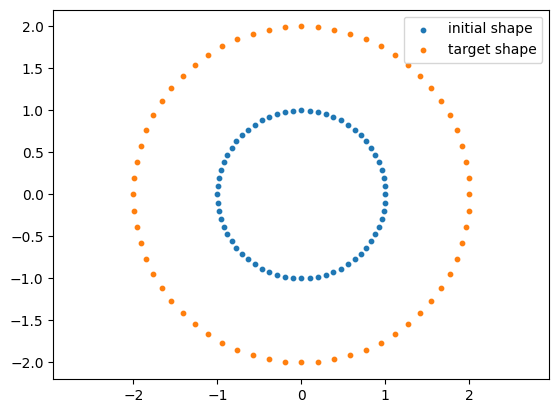

In [223]:
S0 = sample_ellipse(n_samples, scale=1.0)
ST = sample_ellipse(n_samples, scale=2.0)
print("S0 shape: ", S0.shape)
print("ST shape: ", S0.shape)
plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
plt.legend()
plt.axis('equal')
plt.show()

diffusion shape:  (16, 256)


/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


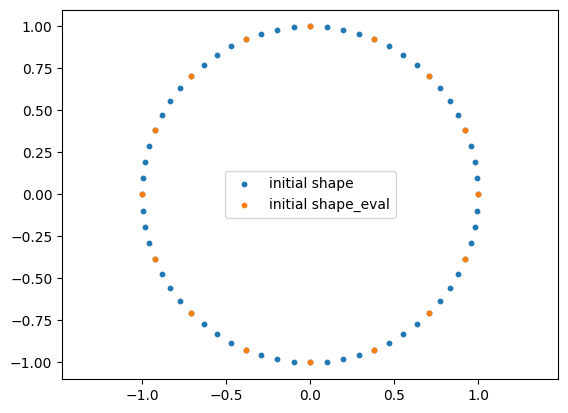

In [224]:
S0_eval = evalute_S_on_bases(S0, ks_truncated)
X_coeffs = jax.random.normal(GDRK, shape=(n_bases, 2), dtype=jnp.complex64)
_diffusion = evaluate_diffusion_coeffs(X_coeffs, S0_eval, sigma=0.5, alpha=1.0)
print("diffusion shape: ", _diffusion.shape)

plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(S0_eval[:, 0], S0_eval[:, 1], s=10, label='initial shape_eval')
plt.axis('equal')
plt.legend()

In [225]:
class GaussianKernelFuncBasisSDE(SDE):
    def __init__(self, config: ConfigDict):
        self.config = config

    def drift(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return jnp.zeros_like(val)
    
    def diffusion(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return evaluate_diffusion_coeffs(val, self.config.S0_eval, self.config.sigma, self.config.alpha)

XT shape: 
 (64, 2)
XT (reconstructed) shape: 
 (32, 2)


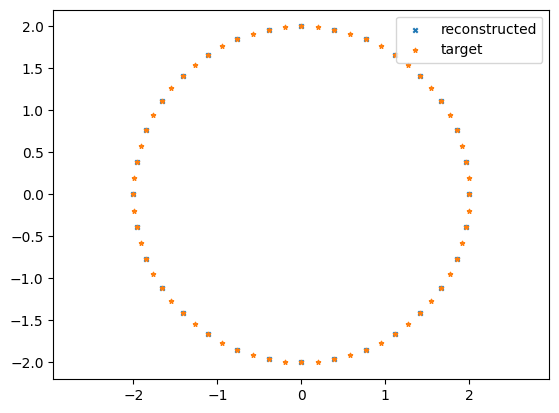

In [226]:
X0 = jnp.zeros((n_bases, 2), dtype=jnp.complex64)

XT = ST - S0
print("XT shape: \n", XT.shape)
XT_coeffs= vmap(partial(jnp.fft.fft, norm="ortho", n=n_samples), in_axes=1, out_axes=1)(XT)
XT_recon = evaluate_X_on_bases(XT_coeffs, n=32)
print("XT (reconstructed) shape: \n", XT_recon.shape)

ST_recon = S0[::2, :] + XT_recon.real
plt.scatter(ST_recon[:, 0], ST_recon[:, 1], s=10, marker='x', label='reconstructed')
plt.scatter(ST[:, 0], ST[:, 1], s=10, marker='*', label='target')
plt.axis('equal')
plt.legend()

In [227]:
sde_config = ConfigDict(
    {
        'S0_eval': S0_eval,
        'T': 1.0,
        'N': 100,
        'dim': 2*n_bases,
        'sigma': 0.3,
        'alpha': 1.0,
    }
)
sde = GaussianKernelFuncBasisSDE(sde_config)
bridge = DiffusionBridge(sde)

In [228]:
forward_uncond = euler_maruyama(sde, initial_vals=jnp.expand_dims(X0, axis=0), terminal_vals=None)

Xs_coeffs shape:  (1, 100, 16, 2)
Xs_recon shape:  (1, 100, 64, 2)
Ss shape:  (1, 100, 64, 2)


(-1.5273902058601379,
 1.509091818332672,
 -1.4133697211742402,
 1.5121101796627046)

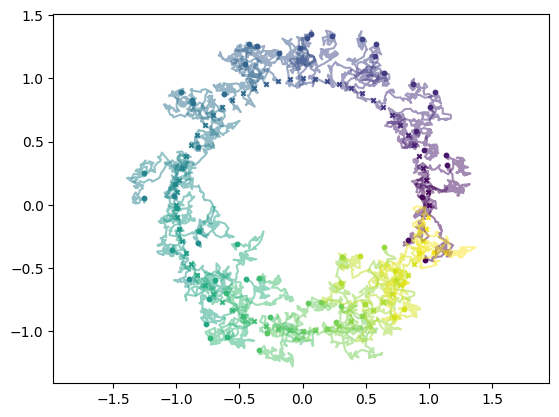

In [229]:
Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: ", Xs_coeffs.shape)
Xs_recon = vmap(vmap(partial(evaluate_X_on_bases, n=n_samples)))(Xs_coeffs)
print("Xs_recon shape: ", Xs_recon.shape)

Ss = S0[None, None, :, :] + Xs_recon.real
print("Ss shape: ", Ss.shape)

# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_samples))
for i in range(n_samples):
    plt.scatter(Ss[0, 0, i, 0], Ss[0, 0, i, 1], s=10, marker='x', color=colors[i])
    plt.scatter(Ss[0, -1, i, 0], Ss[0, -1, i, 1], s=10, marker='o', color=colors[i])
    plt.plot(Ss[0, :, i, 0], Ss[0, :, i, 1], color=colors[i], alpha=0.5)
plt.axis('equal')

#### Butterflies

In [230]:
from sdebridge.data_processing import butterfly1_pts, butterfly2_pts

In [325]:
n_bases = 8
n_samples = 120

ks_truncated = jnp.fft.fftfreq(n_bases, d=1.0/(2.0*np.pi))  # (n_bases, )
kks_truncated = jnp.stack(jnp.meshgrid(ks_truncated, ks_truncated, indexing='ij'), axis=-1)

In [326]:
def evaluate_S_on_bases(S: jnp.ndarray) -> jnp.ndarray:
    S_coeffs = vmap(partial(jnp.fft.fft, norm="ortho", n=n_samples), in_axes=1, out_axes=1)(S)
    S_eval = vmap(partial(jnp.fft.irfft, norm="forward", n=n_bases), in_axes=1, out_axes=1)(S_coeffs / np.sqrt(n_samples))
    return S_eval

def evaluate_X_on_bases(X_coeffs: jnp.ndarray, n: int) -> jnp.ndarray:
    X_eval = vmap(partial(jnp.fft.irfft, norm="forward", n=n), in_axes=1, out_axes=1)(X_coeffs / jnp.sqrt(n_samples))
    return X_eval

def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

def evaluate_Q_on_bases(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    kernel_func = partial(gaussian_kernel_2d, sigma=sigma, alpha=alpha)
    St_eval = evaluate_X_on_bases(X_coeffs, n=n_bases) + S0_eval   # (n_bases, 2)
    Q_eval = vmap(
        vmap(
            vmap(kernel_func, 
                 (None, 0), 
                 0), 
            (None, 1), 
            1), 
        (0, None), 
        0)(St_eval, kks_truncated)
    return Q_eval

def evaluate_Q_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_eval = evaluate_Q_on_bases(X_coeffs, S0_eval, sigma, alpha) # (n_bases, n_bases, n_bases)
    Q_coeffs = vmap(partial(jnp.fft.fft2, norm="forward"))(Q_eval)    # (n_bases, n_bases, n_bases)
    Q_coeffs_shifted = jnp.fft.fftshift(Q_coeffs, axes=(-2, -1))
    Q_coeffs_shifted = Q_coeffs_shifted.reshape(n_bases, -1)    # (n_bases, n_bases ** 2)
    return Q_coeffs_shifted

def evaluate_diffusion_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_coeffs_shifted = evaluate_Q_coeffs(X_coeffs, S0_eval, sigma, alpha) # (n_bases, n_bases ** 2)
    fs = vmap(fourier_base_func_1d, (0, None))(jnp.arange(n_bases), ks_truncated)
    return jnp.matmul(fs, Q_coeffs_shifted)    # (n_bases, n_bases**2)

S0 shape:  (120, 2)
ST shape:  (120, 2)


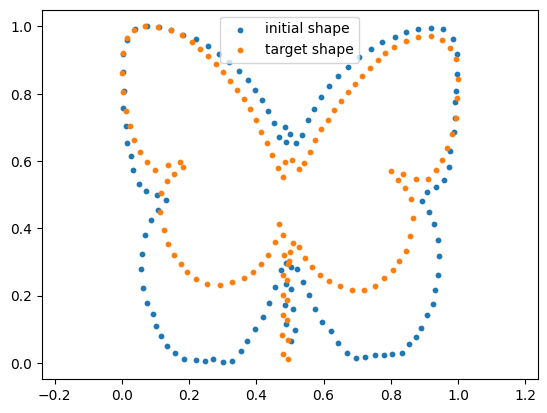

In [327]:
S0 = jnp.array(butterfly1_pts())[:, ::1861][:, ::1].transpose()
ST = jnp.array(butterfly2_pts())[:, ::475][:, ::1].transpose()
print("S0 shape: ", S0.shape)
print("ST shape: ", S0.shape)
plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
plt.legend()
plt.axis('equal')
plt.show()

S0_eval shape:  (8, 2)


/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


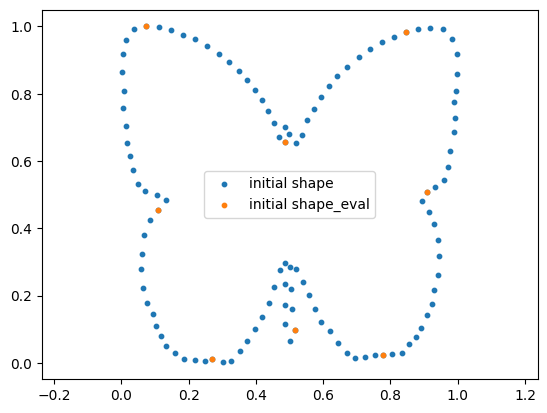

In [328]:
S0_eval = evalute_S_on_bases(S0, ks_truncated)
print("S0_eval shape: ", S0_eval.shape)

plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(S0_eval[:, 0], S0_eval[:, 1], s=10, label='initial shape_eval')
plt.axis('equal')
plt.legend()

In [329]:
class GaussianKernelFuncBasisSDE(SDE):
    def __init__(self, config: ConfigDict):
        self.config = config

    def drift(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return jnp.zeros_like(val)
    
    def diffusion(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return evaluate_diffusion_coeffs(val, self.config.S0_eval, self.config.sigma, self.config.alpha)

XT shape: 
 (120, 2)
XT (reconstructed) shape: 
 (120, 2)


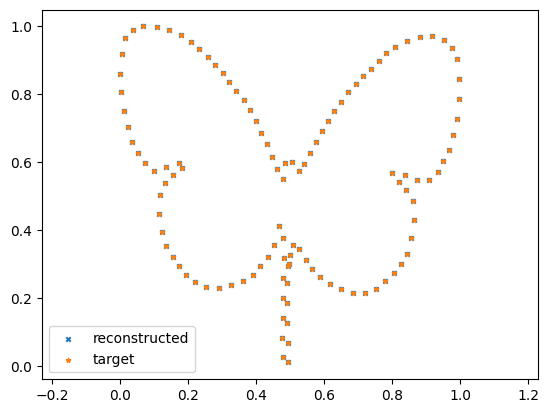

In [330]:
X0 = jnp.zeros((n_bases, 2), dtype=jnp.complex64)

XT = ST - S0
print("XT shape: \n", XT.shape)
XT_coeffs= vmap(partial(jnp.fft.fft, norm="ortho", n=n_samples), in_axes=1, out_axes=1)(XT)
XT_recon = evaluate_X_on_bases(XT_coeffs, n=n_samples)
print("XT (reconstructed) shape: \n", XT_recon.shape)

ST_recon = S0 + XT_recon.real
plt.scatter(ST_recon[:, 0], ST_recon[:, 1], s=10, marker='x', label='reconstructed')
plt.scatter(ST[:, 0], ST[:, 1], s=10, marker='*', label='target')
plt.axis('equal')
plt.legend()

In [331]:
sde_config = ConfigDict(
    {
        'S0_eval': S0_eval,
        'T': 1.0,
        'N': 100,
        'dim': 2*n_bases,
        'sigma': 0.2,
        'alpha': 0.7,
    }
)
sde = GaussianKernelFuncBasisSDE(sde_config)
bridge = DiffusionBridge(sde)

In [332]:
forward_uncond = euler_maruyama(sde, initial_vals=jnp.expand_dims(X0, axis=0), terminal_vals=None)

Xs_coeffs shape:  (1, 100, 8, 2)
Xs_recon shape:  (1, 100, 120, 2)
Ss shape:  (1, 100, 120, 2)


(-0.1210763432085514,
 1.0893417425453662,
 -0.10194732993841171,
 1.1266364380717278)

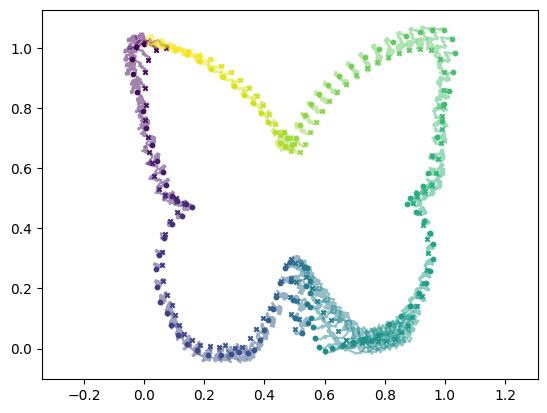

In [333]:
Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: ", Xs_coeffs.shape)
Xs_recon = vmap(vmap(partial(evaluate_X_on_bases, n=n_samples)))(Xs_coeffs)
print("Xs_recon shape: ", Xs_recon.shape)

Ss = S0[None, None, :, :] + Xs_recon.real
print("Ss shape: ", Ss.shape)

# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_samples))
for i in range(n_samples):
    plt.scatter(Ss[0, 0, i, 0], Ss[0, 0, i, 1], s=10, marker='x', color=colors[i])
    plt.scatter(Ss[0, -1, i, 0], Ss[0, -1, i, 1], s=10, marker='o', color=colors[i])
    plt.plot(Ss[0, :, i, 0], Ss[0, :, i, 1], color=colors[i], alpha=0.5)
plt.axis('equal')